In [1]:
pip install pycountry_convert

     |████████████████████████████████| 208 kB 1.1 MB/s            
Note: you may need to restart the kernel to use updated packages.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import pycountry_convert as pc
import pycountry
import plotly.express as px
import numpy as np
import pandas as pd
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/novel-corona-virus-2019-dataset/time_series_covid_19_deaths_US.csv
/kaggle/input/novel-corona-virus-2019-dataset/time_series_covid_19_recovered.csv
/kaggle/input/novel-corona-virus-2019-dataset/time_series_covid_19_confirmed_US.csv
/kaggle/input/novel-corona-virus-2019-dataset/covid_19_data.csv
/kaggle/input/novel-corona-virus-2019-dataset/time_series_covid_19_confirmed.csv
/kaggle/input/novel-corona-virus-2019-dataset/time_series_covid_19_deaths.csv


In [3]:
#read data into dataframes
covid_data = pd.read_csv("/kaggle/input/novel-corona-virus-2019-dataset/covid_19_data.csv")
print("covid data has the shape : {} ".format(covid_data.shape) )
print("{} rows and {} columns  \n\n".format(covid_data.shape[0],covid_data.shape[1] ) )

covid data has the shape : (306429, 8) 
306429 rows and 8 columns  




In [4]:
covid_data.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


In [5]:
covid_data.rename(columns={'Province/State': 'State', 'Country/Region': 'Country'}, inplace=True)
covid_data['State'] = covid_data['State'].fillna('Unknown')
covid_data['diffs'] = covid_data.groupby(['Country','State'])['Confirmed'].diff().fillna(0)
covid_data.loc[covid_data.groupby(['Country','State'])['diffs'].head(1).index, 'diffs'] = covid_data['Confirmed']
covid_data.loc[covid_data.diffs < 0, 'diffs'] = 0
#covid_data.head()
#covid_data['diffs'] = covid_data.groupby(['Country/Region','Province/State'])['Confirmed'].transform(lambda x: x.diff()) 
#covid_data.loc[covid_data['diffs'].isnull(), 'diffs'] = covid_data['Confirmed']
#covid_data.loc[covid_data['Confirmed']==0, 'diffs'] = 0

In [6]:
covid_data.head()

,SNo,ObservationDate,State,Country,Last Update,Confirmed,Deaths,Recovered,diffs
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0,1.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0,14.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0,6.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0,1.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0,0.0


In [7]:
covid_data["Country"].unique()

array(['Mainland China', 'Hong Kong', 'Macau', 'Taiwan', 'US', 'Japan',
       'Thailand', 'South Korea', 'China', 'Kiribati', 'Singapore',
       'Philippines', 'Malaysia', 'Vietnam', 'Australia', 'Mexico',
       'Brazil', 'Colombia', 'France', 'Nepal', 'Canada', 'Cambodia',
       'Sri Lanka', 'Ivory Coast', 'Germany', 'Finland',
       'United Arab Emirates', 'India', 'Italy', 'UK', 'Russia', 'Sweden',
       'Spain', 'Belgium', 'Others', 'Egypt', 'Iran', 'Israel', 'Lebanon',
       'Iraq', 'Oman', 'Afghanistan', 'Bahrain', 'Kuwait', 'Austria',
       'Algeria', 'Croatia', 'Switzerland', 'Pakistan', 'Georgia',
       'Greece', 'North Macedonia', 'Norway', 'Romania', 'Denmark',
       'Estonia', 'Netherlands', 'San Marino', ' Azerbaijan', 'Belarus',
       'Iceland', 'Lithuania', 'New Zealand', 'Nigeria', 'North Ireland',
       'Ireland', 'Luxembourg', 'Monaco', 'Qatar', 'Ecuador',
       'Azerbaijan', 'Czech Republic', 'Armenia', 'Dominican Republic',
       'Indonesia', 'Portugal

In [8]:
def do_fuzzy_search(country):
    try:
        result = pycountry.countries.search_fuzzy(country)
    except Exception:
        return np.nan
    else:
        return result[0].alpha_3
    
iso_map = {country: do_fuzzy_search(country) for country in covid_data["Country"].unique()}
covid_data["country_code"] = covid_data["Country"].map(iso_map)    
    

In [9]:
print("data are collected between the date {} and the date {} ".format( min(covid_data["ObservationDate"]) , max(covid_data["ObservationDate"] ) ) )

data are collected between the date 01/01/2021 and the date 12/31/2020 


### Check , if the Observationdate is equal to last Update in all observations.

Convert "ObservationDate" and "Last Update" to datetime objects

In [10]:
covid_data['ObservationDate'] = pd.to_datetime(covid_data['ObservationDate'])
covid_data['Last Update'] = pd.to_datetime(covid_data['Last Update'])
covid_data['ObservationMonth'] = covid_data['ObservationDate'].dt.to_period('M')

In [11]:
ratio1 = len( covid_data.loc[~(covid_data['ObservationDate'].dt.date == covid_data['Last Update'].dt.date)] ) / covid_data.shape[0]
ratio2 = len( covid_data.loc[(covid_data['ObservationDate'].dt.date < covid_data['Last Update'].dt.date)] ) / covid_data.shape[0]
ratio3 = len( covid_data.loc[(covid_data['ObservationDate'].dt.date > covid_data['Last Update'].dt.date)] ) / covid_data.shape[0]
print("Nearly {}% of the data have the observation date not equal to the last update date ".format(round(ratio1, 2)))
print("Nearly {}% of the data have the last update date comes after the observationdate ".format(round(ratio2, 2)))
print("Nearly {}% of the data have the observation date after the last update date ".format(round(ratio3, 2)))

Nearly 0.95% of the data have the observation date not equal to the last update date 
Nearly 0.94% of the data have the last update date comes after the observationdate 
Nearly 0.01% of the data have the observation date after the last update date 


This high number of percentage , where the two dates are not equal references to the fact that the data could not be collected correctly in the right tine , whereas new cases to a specifc day were discovered later on. 

### Explore Confirmed

In [12]:
covidNumberPerDay = covid_data.groupby(by=['ObservationDate'], as_index=False)['diffs'].sum().reset_index()
covidNumberPerDay = covidNumberPerDay.assign(numberAccumuliert=covidNumberPerDay.diffs.cumsum())
covidNumberPerDay['ObservationDate'] = pd.to_datetime(covidNumberPerDay['ObservationDate'])
covidNumberPerDay = covidNumberPerDay.set_index('ObservationDate')

covidNumberPerMonth = covid_data.groupby(by=['ObservationMonth'], as_index=False)['diffs'].sum().reset_index()
covidNumberPerMonth = covidNumberPerMonth.assign(numberAccumuliert=covidNumberPerMonth.diffs.cumsum())
covidNumberPerMonth = covidNumberPerMonth.set_index('ObservationMonth')
covidNumberPerMonth.index=covidNumberPerMonth.index.to_series().astype(str)

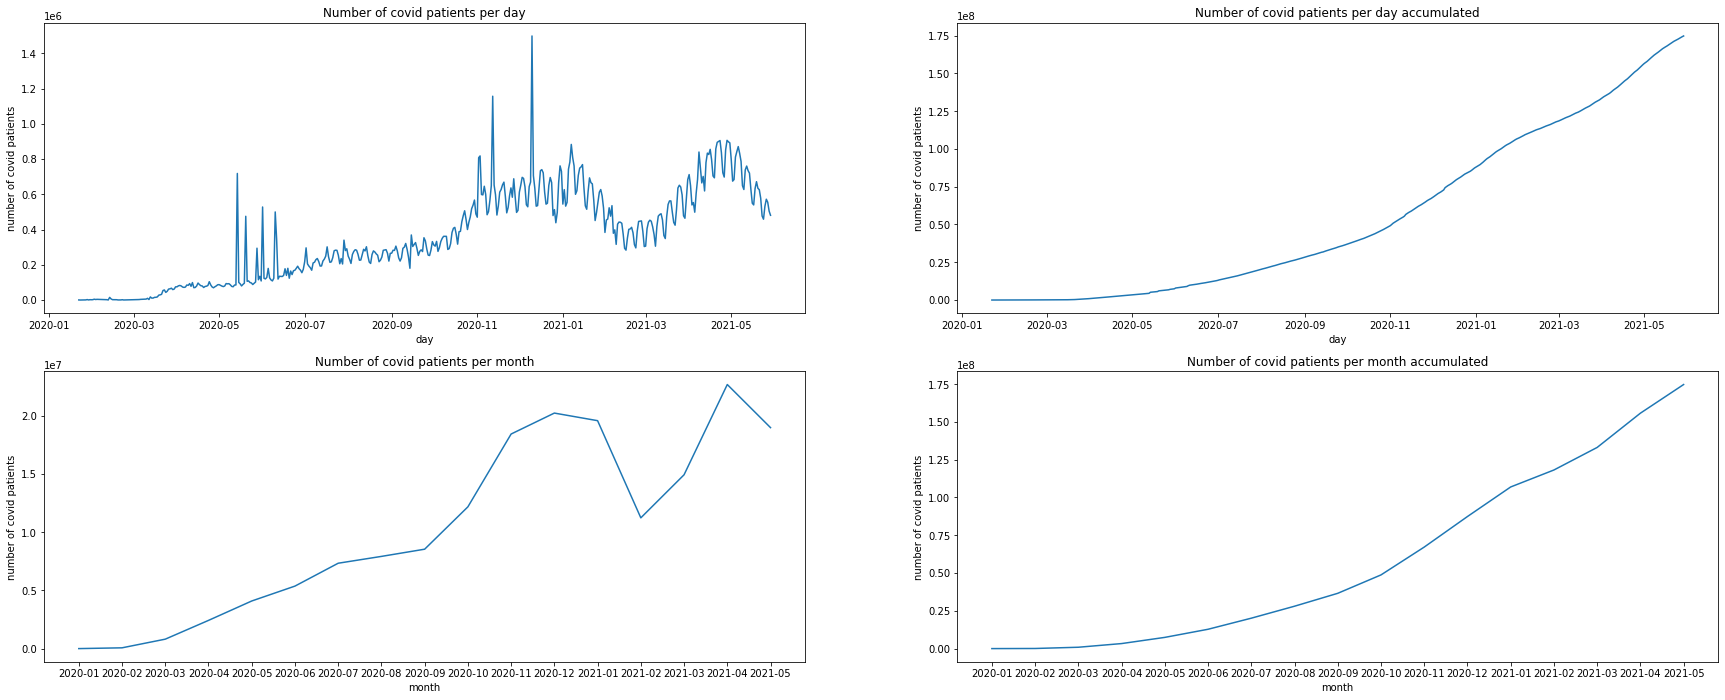

In [13]:
fig = plt.figure(figsize=(30, 140))
a = 22
b = 2

plt.subplot(a,b,1) 
plt.plot(covidNumberPerDay["diffs"])
plt.title('Number of covid patients per day')
plt.ylabel('number of covid patients')
plt.xlabel('day')
plt.grid(False)


plt.subplot(a,b,2) 
plt.plot(covidNumberPerDay["numberAccumuliert"])
plt.title('Number of covid patients per day accumulated')
plt.ylabel('number of covid patients')
plt.xlabel('day')
plt.grid(False)

plt.subplot(a,b,3) 
plt.plot(covidNumberPerMonth["diffs"])
plt.title('Number of covid patients per month')
plt.ylabel('number of covid patients')
plt.xlabel('month')
plt.grid(False)

plt.subplot(a,b,4) 
plt.plot(covidNumberPerMonth["numberAccumuliert"])
plt.title('Number of covid patients per month accumulated')
plt.ylabel('number of covid patients')
plt.xlabel('month')
plt.grid(False)

    
plt.show() 

In [14]:
covid_data['Country'] = covid_data['Country'].replace('Mainland China','China')
covid_data['Country'] = covid_data['Country'].replace('US','United States of America')
covid_data['Country'] = covid_data['Country'].replace('UK','United Kingdom of Great Britain and Northern Ireland')
covid_data['Country'] = covid_data['Country'].replace(' Azerbaijan','Azerbaijan')
covid_data['Country'] = covid_data['Country'].replace('North Ireland','United Kingdom of Great Britain and Northern Ireland')
covid_data['Country'] = covid_data['Country'].replace('Saint Barthelemy','Saint Barthélemy')
covid_data['Country'] = covid_data['Country'].replace('Vatican City','Italy')
covid_data['Country'] = covid_data['Country'].replace('Republic of Ireland','Ireland')
covid_data['Country'] = covid_data['Country'].replace('occupied Palestinian territory','Jordan')
covid_data['Country'] = covid_data['Country'].replace("('St. Martin',)",'Saint Martin')
covid_data['Country'] = covid_data['Country'].replace('Channel Islands','United Kingdom of Great Britain and Northern Ireland')
covid_data['Country'] = covid_data['Country'].replace('Holy See','Holy See')
covid_data['Country'] = covid_data['Country'].replace('Congo (Kinshasa)','Congo')
covid_data['Country'] = covid_data['Country'].replace('Reunion','Réunion')
covid_data['Country'] = covid_data['Country'].replace('Curacao','Curaçao')
covid_data['Country'] = covid_data['Country'].replace('Congo (Brazzaville)','Congo')
covid_data['Country'] = covid_data['Country'].replace('The Bahamas','Bahamas')
covid_data['Country'] = covid_data['Country'].replace('The Gambia','Gambia')
covid_data['Country'] = covid_data['Country'].replace('Gambia, The','Gambia')
covid_data['Country'] = covid_data['Country'].replace('Bahamas, The','Bahamas')
covid_data['Country'] = covid_data['Country'].replace('East Timor, The','Timor-Leste')
covid_data['Country'] = covid_data['Country'].replace('East Timor','Timor-Leste')
covid_data['Country'] = covid_data['Country'].replace('West Bank and Gaza','Jordan')

unknown_countreis = ["Others","Holy See","Kosovo","Timor-Leste","Diamond Princess","Burma","MS Zaandam"]


In [15]:
def country_to_continent(country_name):
    country_alpha2 = pc.country_name_to_country_alpha2(country_name)
    country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
    country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
    return country_continent_name

covid_data['Continent'] = covid_data['Country'].apply(lambda x: country_to_continent(x) if (x not in unknown_countreis) else x)

covid_data.loc[covid_data['Country'] == 'Holy See', 'Continent'] = 'Europe'
covid_data.loc[covid_data['Country'] == 'Kosovo', 'Continent'] = 'Europe'
covid_data.loc[covid_data['Country'] == 'Timor-Leste', 'Continent'] = 'Asia'
covid_data.loc[covid_data['Country'] == 'Diamond Princess', 'Continent'] = 'Europe'
covid_data.loc[covid_data['Country'] == 'Burma', 'Continent'] = 'Asia'
covid_data.loc[covid_data['Country'] == 'MS Zaandam', 'Continent'] = 'Europe'


#### Entire world 

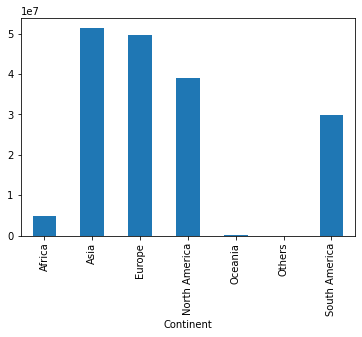

In [16]:
entire_world = covid_data.groupby(['Continent'])["diffs"].sum().plot(kind="bar")

In [17]:
entire_world = covid_data.groupby(['Continent'])["diffs"].sum().reset_index()
entire_world['pres'] = (entire_world['diffs'] / 
                        entire_world['diffs'].sum()) * 100
entire_world.head(10)

,Continent,diffs,pres
0,Africa,4821604.0,2.759033
1,Asia,51320846.0,29.366977
2,Europe,49584872.0,28.373612
3,North America,38985770.0,22.308560
4,Oceania,49073.0,0.028081
5,Others,783.0,0.000448
6,South America,29994048.0,17.163289


In [18]:
covidData_Europe = covid_data.loc[covid_data.Continent=='Europe'].groupby(by=['ObservationMonth'], as_index=False)['diffs'].sum().reset_index().set_index('ObservationMonth')
covidData_Europe.index = covidData_Europe.index.to_series().astype(str)

covidData_NorthAmerica = covid_data.loc[covid_data.Continent=='North America'].groupby(by=['ObservationMonth'], as_index=False)['diffs'].sum().reset_index().set_index('ObservationMonth')
covidData_NorthAmerica.index = covidData_NorthAmerica.index.to_series().astype(str)

covidData_SouthAmerica = covid_data.loc[covid_data.Continent=='South America'].groupby(by=['ObservationMonth'], as_index=False)['diffs'].sum().reset_index().set_index('ObservationMonth')
covidData_SouthAmerica.index = covidData_SouthAmerica.index.to_series().astype(str)

covidData_Asia = covid_data.loc[covid_data.Continent=='Asia'].groupby(by=['ObservationMonth'], as_index=False)['diffs'].sum().reset_index().set_index('ObservationMonth')
covidData_Asia.index = covidData_Asia.index.to_series().astype(str)

covidData_Africa = covid_data.loc[covid_data.Continent=='Africa'].groupby(by=['ObservationMonth'], as_index=False)['diffs'].sum().reset_index().set_index('ObservationMonth')
covidData_Africa.index = covidData_Africa.index.to_series().astype(str)

covidData_Oceania = covid_data.loc[covid_data.Continent=='Oceania'].groupby(by=['ObservationMonth'], as_index=False)['diffs'].sum().reset_index().set_index('ObservationMonth')
covidData_Oceania.index = covidData_Oceania.index.to_series().astype(str)

covidData_Others = covid_data.loc[covid_data.Continent=='Others'].groupby(by=['ObservationMonth'], as_index=False)['diffs'].sum().reset_index().set_index('ObservationMonth')
covidData_Others.index = covidData_Others.index.to_series().astype(str)

 
covidData_Europe.head()

,index,diffs
ObservationMonth,,
2020-01,0,18.0
2020-02,1,1456.0
2020-03,2,495129.0
2020-04,3,925541.0
2020-05,4,1252851.0


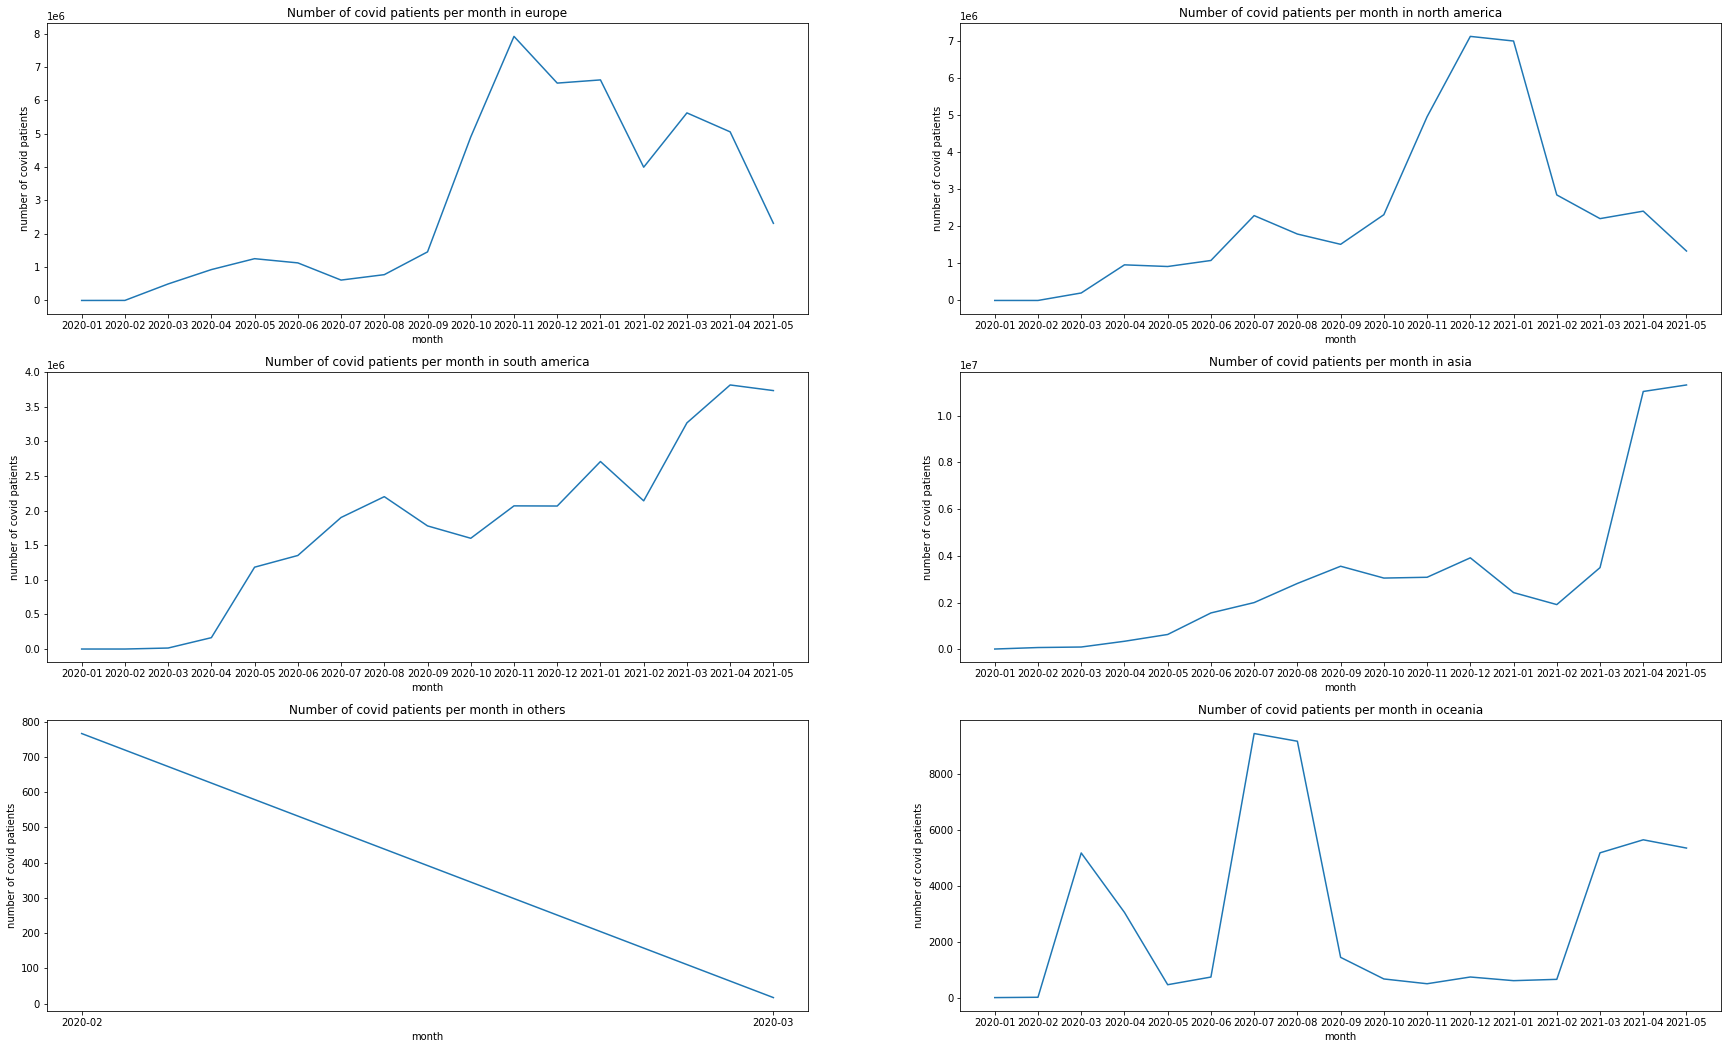

In [19]:
fig = plt.figure(figsize=(30, 140))
a = 22
b = 2

plt.subplot(a,b,1) 
plt.plot(covidData_Europe["diffs"])
plt.title('Number of covid patients per month in europe')
plt.ylabel('number of covid patients')
plt.xlabel('month')
plt.grid(False)


plt.subplot(a,b,2) 
plt.plot(covidData_NorthAmerica["diffs"])
plt.title('Number of covid patients per month in north america')
plt.ylabel('number of covid patients')
plt.xlabel('month')
plt.grid(False)

plt.subplot(a,b,3) 
plt.plot(covidData_SouthAmerica["diffs"])
plt.title('Number of covid patients per month in south america')
plt.ylabel('number of covid patients')
plt.xlabel('month')
plt.grid(False)

plt.subplot(a,b,4) 
plt.plot(covidData_Asia["diffs"])
plt.title('Number of covid patients per month in asia')
plt.ylabel('number of covid patients')
plt.xlabel('month')
plt.grid(False)

plt.subplot(a,b,5) 
plt.plot(covidData_Others["diffs"])
plt.title('Number of covid patients per month in others')
plt.ylabel('number of covid patients')
plt.xlabel('month')
plt.grid(False)

plt.subplot(a,b,6) 
plt.plot(covidData_Oceania["diffs"])
plt.title('Number of covid patients per month in oceania')
plt.ylabel('number of covid patients')
plt.xlabel('month')
plt.grid(False)


    
plt.show() 

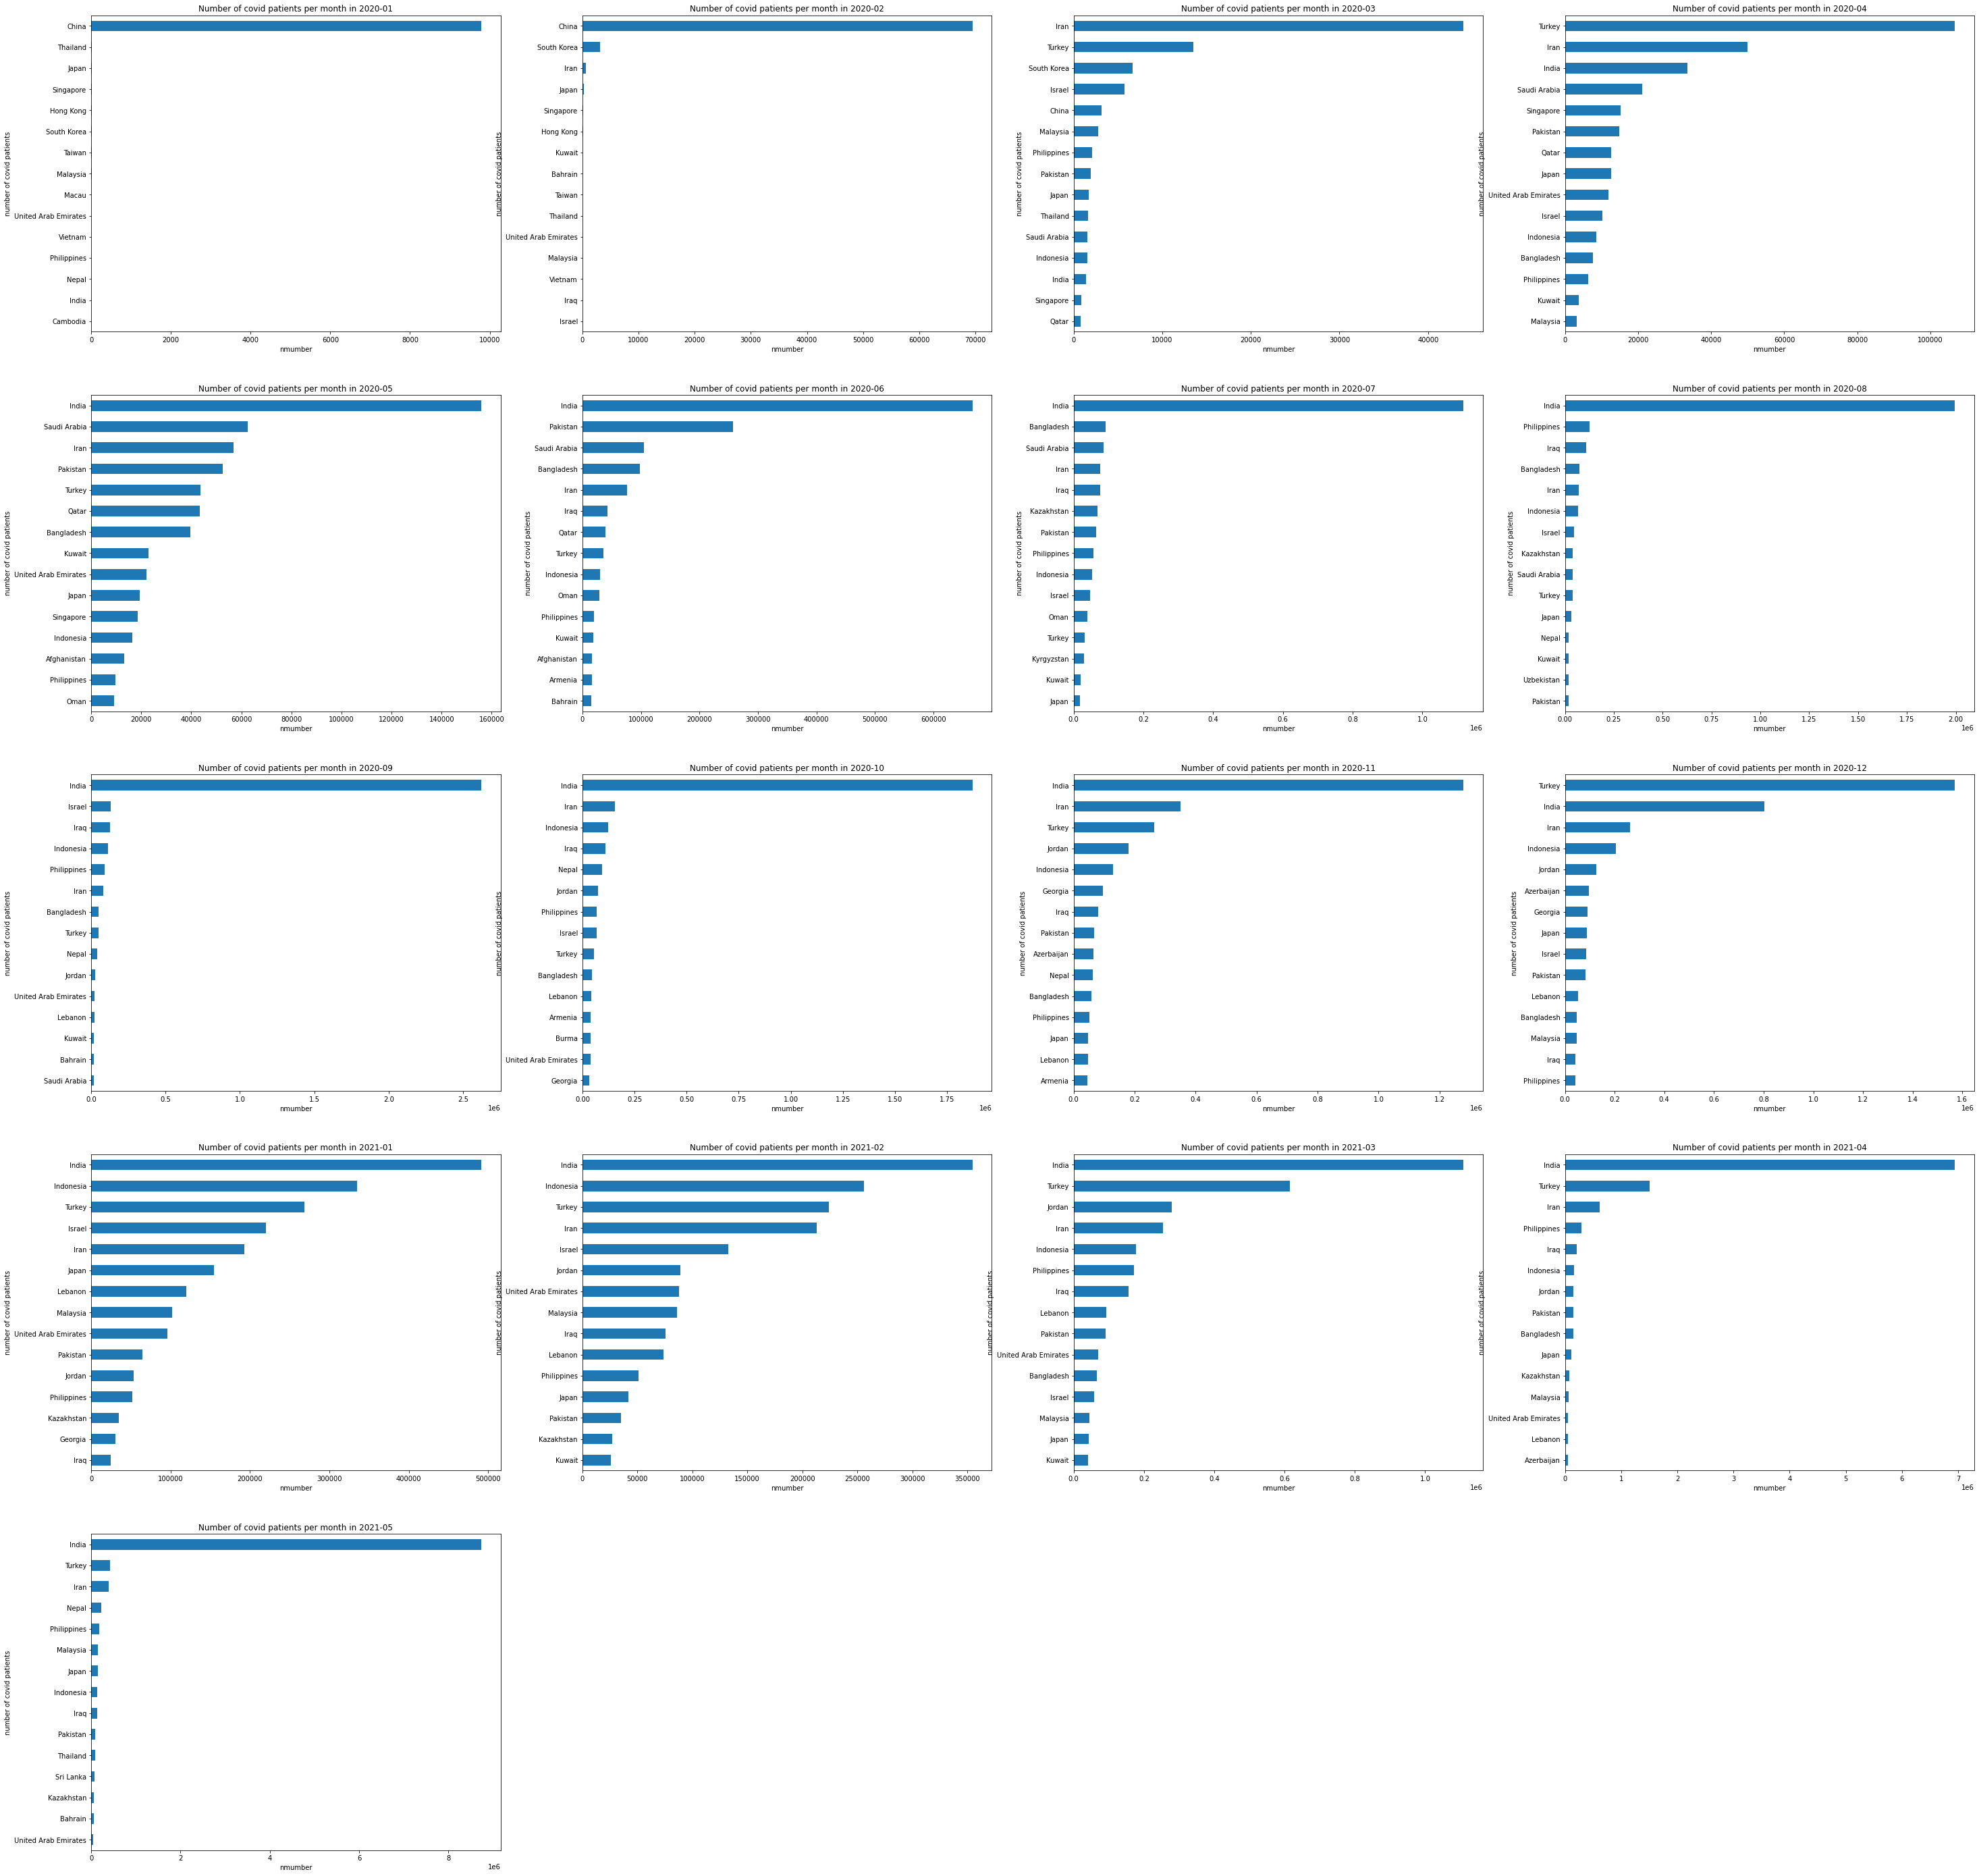

In [20]:
all_months = covid_data['ObservationMonth'].unique()
asia = covid_data.loc[covid_data.Continent=="Asia"]

fig = plt.figure(figsize=(50, 50))
a = 5
b = 4

for index, month in enumerate(all_months):
    
    plt.subplot(a,b,index+1) 
    asia.loc[asia.ObservationMonth==month].groupby(['Country'])["diffs"].sum().nlargest(15).sort_values(ascending=True).plot(kind="barh")
    plt.title('Number of covid patients per month in {}'.format(month))
    plt.ylabel('number of covid patients')
    plt.xlabel('nmumber')
    plt.grid(False)
    
plt.show() 

In [21]:
covidNumberPerMonth = covidNumberPerMonth.reset_index()

In [22]:
covidNumberPerMonth.head()

,ObservationMonth,index,diffs,numberAccumuliert
0,2020-01,0,9933.0,9933.0
1,2020-02,1,76233.0,86166.0
2,2020-03,2,818894.0,905060.0
3,2020-04,3,2429624.0,3334684.0
4,2020-05,4,4094110.0,7428794.0


In [23]:
data_all = covid_data.groupby(['ObservationMonth','Continent'])['diffs'].sum().reset_index()
data_all = data_all.loc[(data_all.Continent=='Europe')|(data_all.Continent=='Asia')]
data_all['ObservationMonth']=data_all['ObservationMonth'].astype(str)

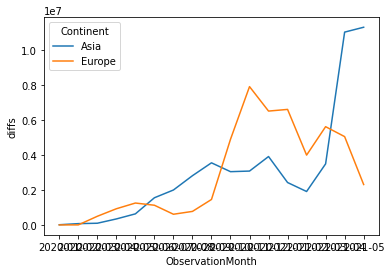

In [24]:
import seaborn as sns 
sns.lineplot(x = "ObservationMonth", y = "diffs", hue='Continent', data = data_all)
plt.show()

### Asia

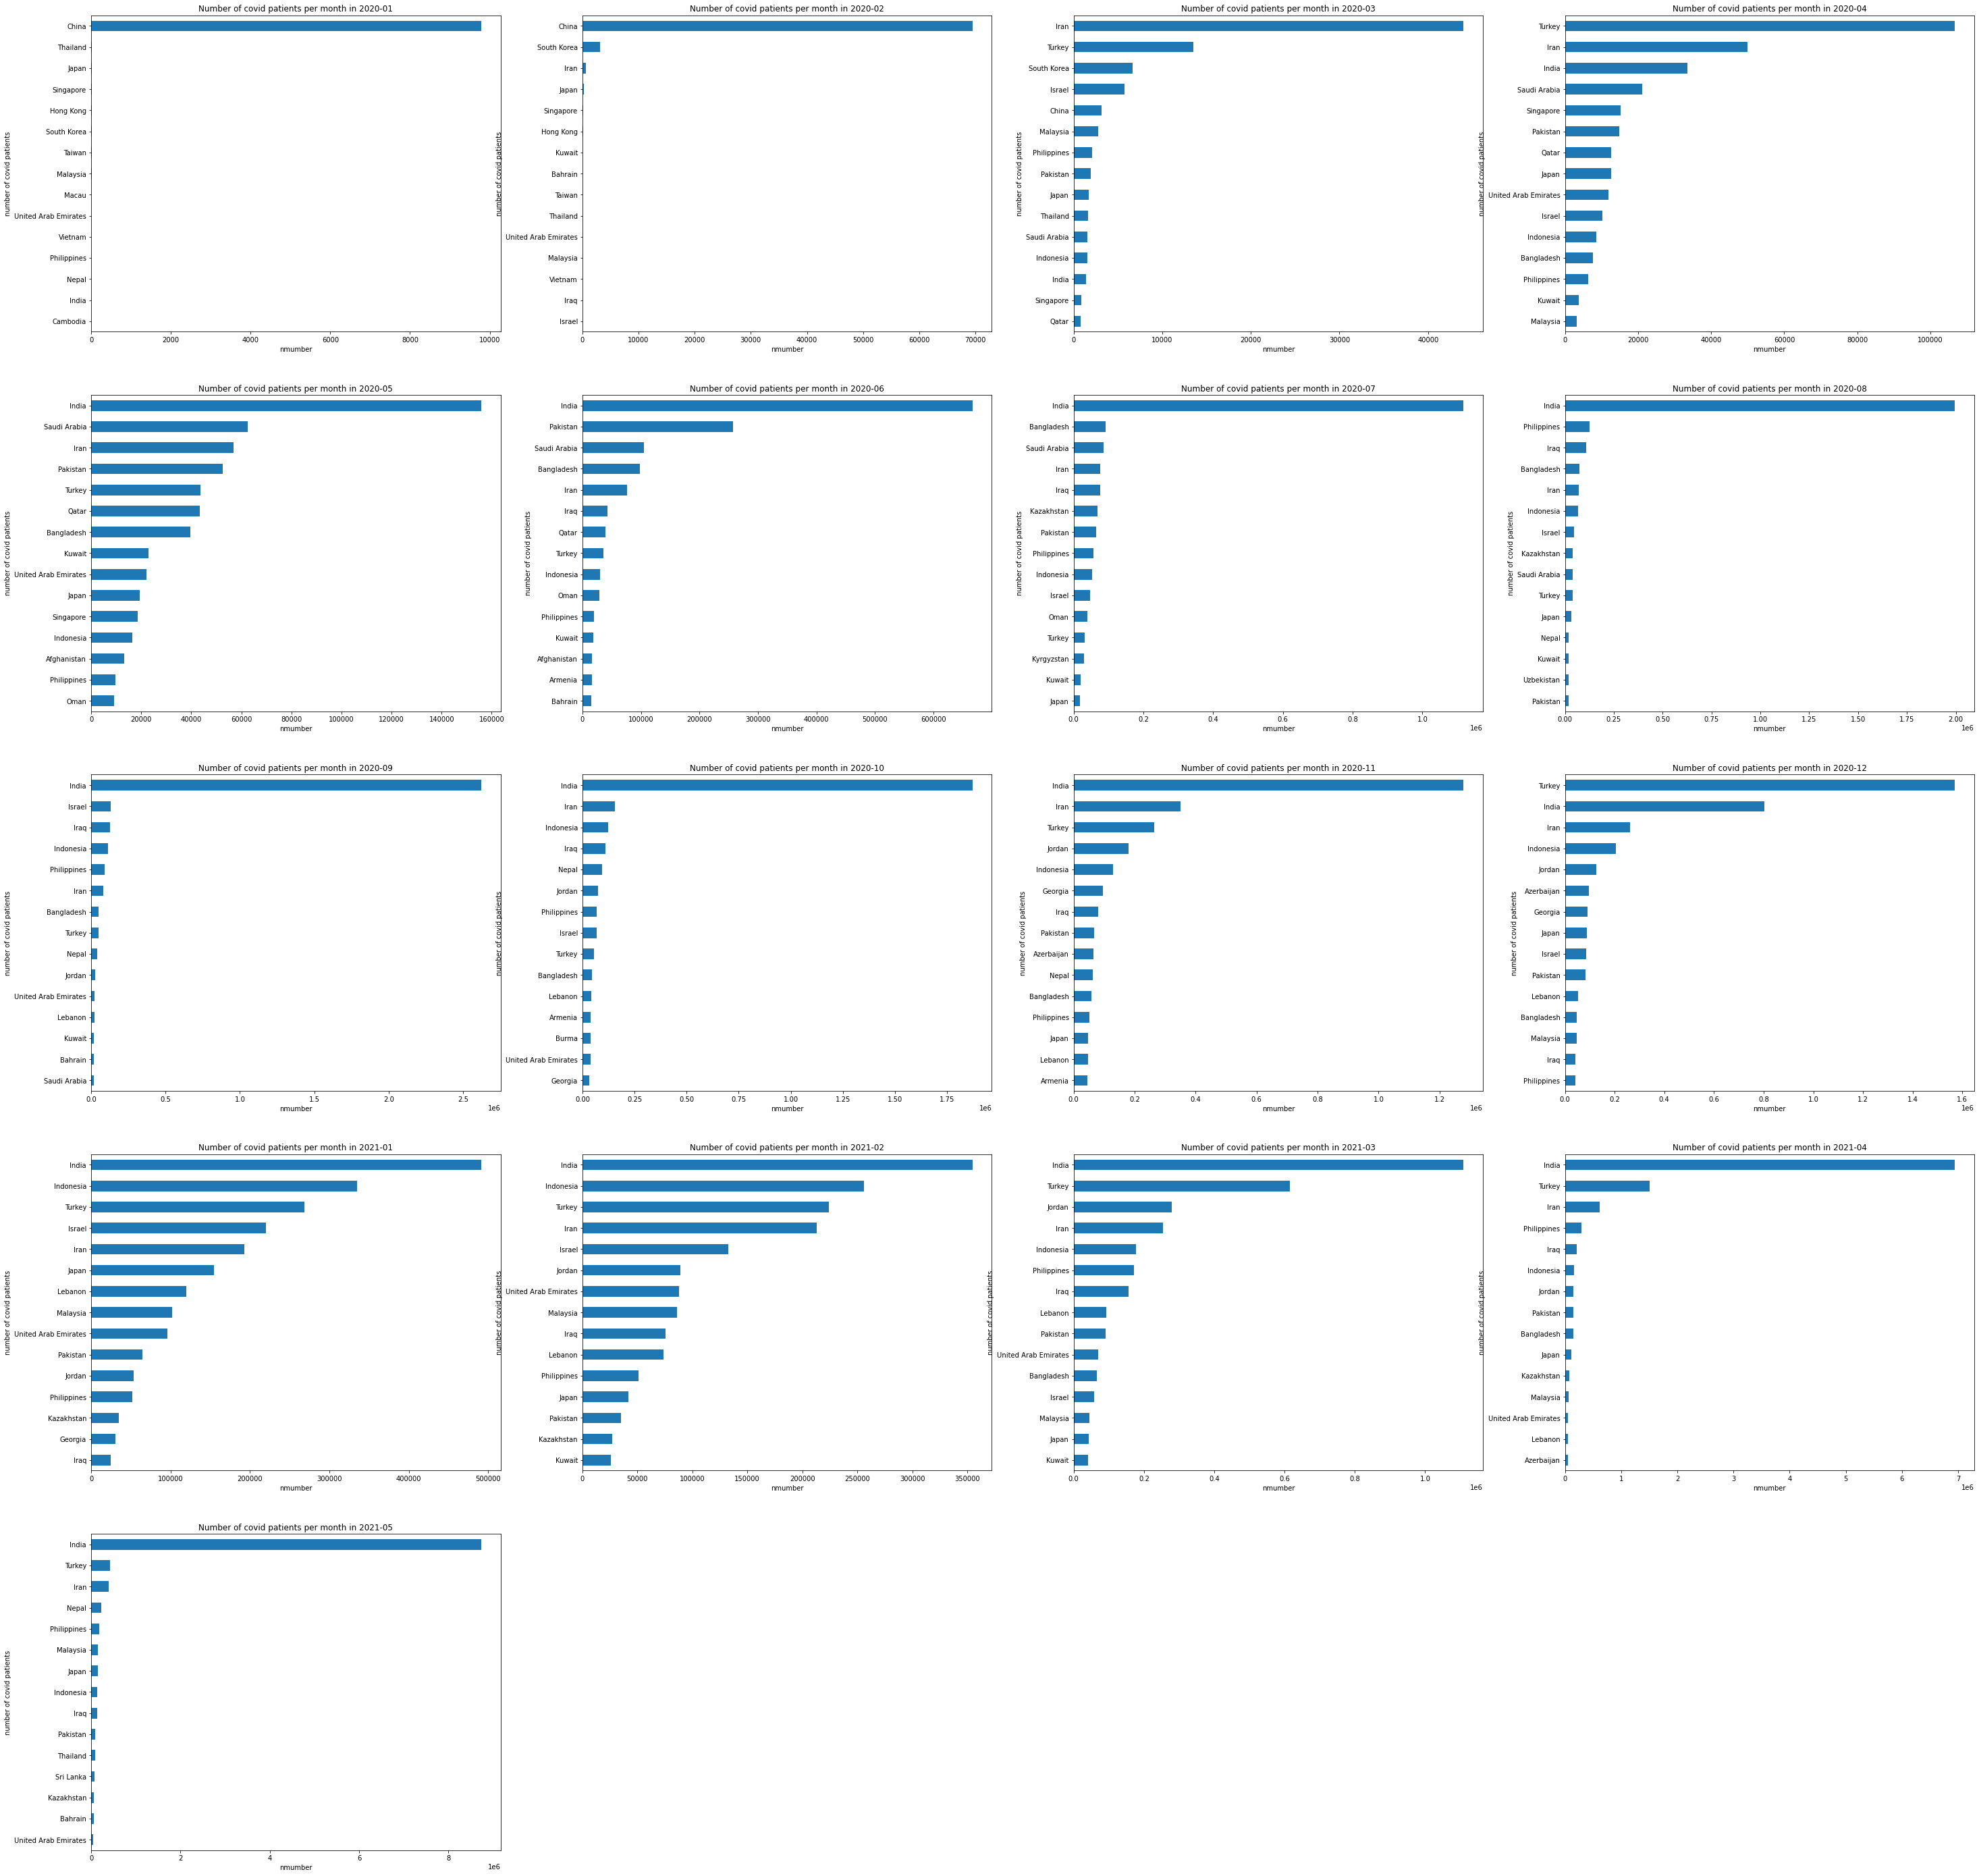

In [25]:
all_months = covid_data['ObservationMonth'].unique()
asia = covid_data.loc[covid_data.Continent=="Asia"]

fig = plt.figure(figsize=(50, 50))
a = 5
b = 4

for index, month in enumerate(all_months):
    
    plt.subplot(a,b,index+1) 
    asia.loc[asia.ObservationMonth==month].groupby(['Country'])["diffs"].sum().nlargest(15).sort_values(ascending=True).plot(kind="barh")
    plt.title('Number of covid patients per month in {}'.format(month))
    plt.ylabel('number of covid patients')
    plt.xlabel('nmumber')
    plt.grid(False)
    
plt.show() 

In [26]:
asia_all_data = covid_data.loc[covid_data.Continent=="Asia"].groupby(['Country'])["diffs"].sum().reset_index()
asia_all_data.head()

,Country,diffs
0,Afghanistan,70111.0
1,Armenia,222555.0
2,Azerbaijan,333732.0
3,Bahrain,235704.0
4,Bangladesh,797386.0


In [27]:
asia_all_data.rename(columns={'Country': 'country'}, inplace=True)

np.random.seed(12)
gapminder = px.data.gapminder().query("year==2007")
#gapminder['counts'] = np.nan


df=pd.merge(gapminder, asia_all_data, how='left', on='country')

fig = px.choropleth(df, locations="iso_alpha",
                    color="diffs", 
                    hover_name="country", # column to add to hover information
                    color_continuous_scale=px.colors.sequential.Plasma)

fig.show()

In [28]:
covid_data_asia = covid_data[covid_data.Continent == 'Asia']

In [29]:
covid_data_asia.head()

,SNo,ObservationDate,State,Country,Last Update,Confirmed,Deaths,Recovered,diffs,country_code,ObservationMonth,Continent
0,1,2020-01-22,Anhui,China,2020-01-22 17:00:00,1.0,0.0,0.0,1.0,NaN,2020-01,Asia
1,2,2020-01-22,Beijing,China,2020-01-22 17:00:00,14.0,0.0,0.0,14.0,NaN,2020-01,Asia
2,3,2020-01-22,Chongqing,China,2020-01-22 17:00:00,6.0,0.0,0.0,6.0,NaN,2020-01,Asia
3,4,2020-01-22,Fujian,China,2020-01-22 17:00:00,1.0,0.0,0.0,1.0,NaN,2020-01,Asia
4,5,2020-01-22,Gansu,China,2020-01-22 17:00:00,0.0,0.0,0.0,0.0,NaN,2020-01,Asia


In [30]:
#select entries with the continent as asia
covid_data_asia["ObservationDate"] = covid_data_asia["ObservationDate"].astype(str)
covid_data_asia.head(10)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,SNo,ObservationDate,State,Country,Last Update,Confirmed,Deaths,Recovered,diffs,country_code,ObservationMonth,Continent
0,1,2020-01-22,Anhui,China,2020-01-22 17:00:00,1.0,0.0,0.0,1.0,NaN,2020-01,Asia
1,2,2020-01-22,Beijing,China,2020-01-22 17:00:00,14.0,0.0,0.0,14.0,NaN,2020-01,Asia
2,3,2020-01-22,Chongqing,China,2020-01-22 17:00:00,6.0,0.0,0.0,6.0,NaN,2020-01,Asia
3,4,2020-01-22,Fujian,China,2020-01-22 17:00:00,1.0,0.0,0.0,1.0,NaN,2020-01,Asia
4,5,2020-01-22,Gansu,China,2020-01-22 17:00:00,0.0,0.0,0.0,0.0,NaN,2020-01,Asia
5,6,2020-01-22,Guangdong,China,2020-01-22 17:00:00,26.0,0.0,0.0,26.0,NaN,2020-01,Asia
6,7,2020-01-22,Guangxi,China,2020-01-22 17:00:00,2.0,0.0,0.0,2.0,NaN,2020-01,Asia
7,8,2020-01-22,Guizhou,China,2020-01-22 17:00:00,1.0,0.0,0.0,1.0,NaN,2020-01,Asia
8,9,2020-01-22,Hainan,China,2020-01-22 17:00:00,4.0,0.0,0.0,4.0,NaN,2020-01,Asia
9,10,2020-01-22,Hebei,China,2020-01-22 17:00:00,1.0,0.0,0.0,1.0,NaN,2020-01,Asia


In [31]:
covid_data_asia = covid_data_asia.groupby(['ObservationDate','country_code'])['diffs'].sum().reset_index()
covid_data_asia['CUMSUM_C'] = covid_data_asia.groupby('country_code')['diffs'].cumsum().fillna(0)
covid_data_asia.tail()

,ObservationDate,country_code,diffs,CUMSUM_C
20402,2021-05-29,TUR,7656.0,5235978.0
20403,2021-05-29,TWN,491.0,7856.0
20404,2021-05-29,UZB,264.0,99844.0
20405,2021-05-29,VNM,512.0,6908.0
20406,2021-05-29,YEM,8.0,6732.0


In [32]:
import plotly.express as px
  
covid_data_asia['ObservationDate'] = covid_data_asia['ObservationDate'].astype(str)    
#plot
fig = px.choropleth(covid_data_asia, locations="country_code",
                    color="CUMSUM_C",
                    hover_name="country_code",
                    animation_frame="ObservationDate",
                    title = "Daily new COVID cases",
                    scope ='asia',  color_continuous_scale=px.colors.sequential.PuRd)
 
fig["layout"].pop("updatemenus")
fig.show()

### Europe

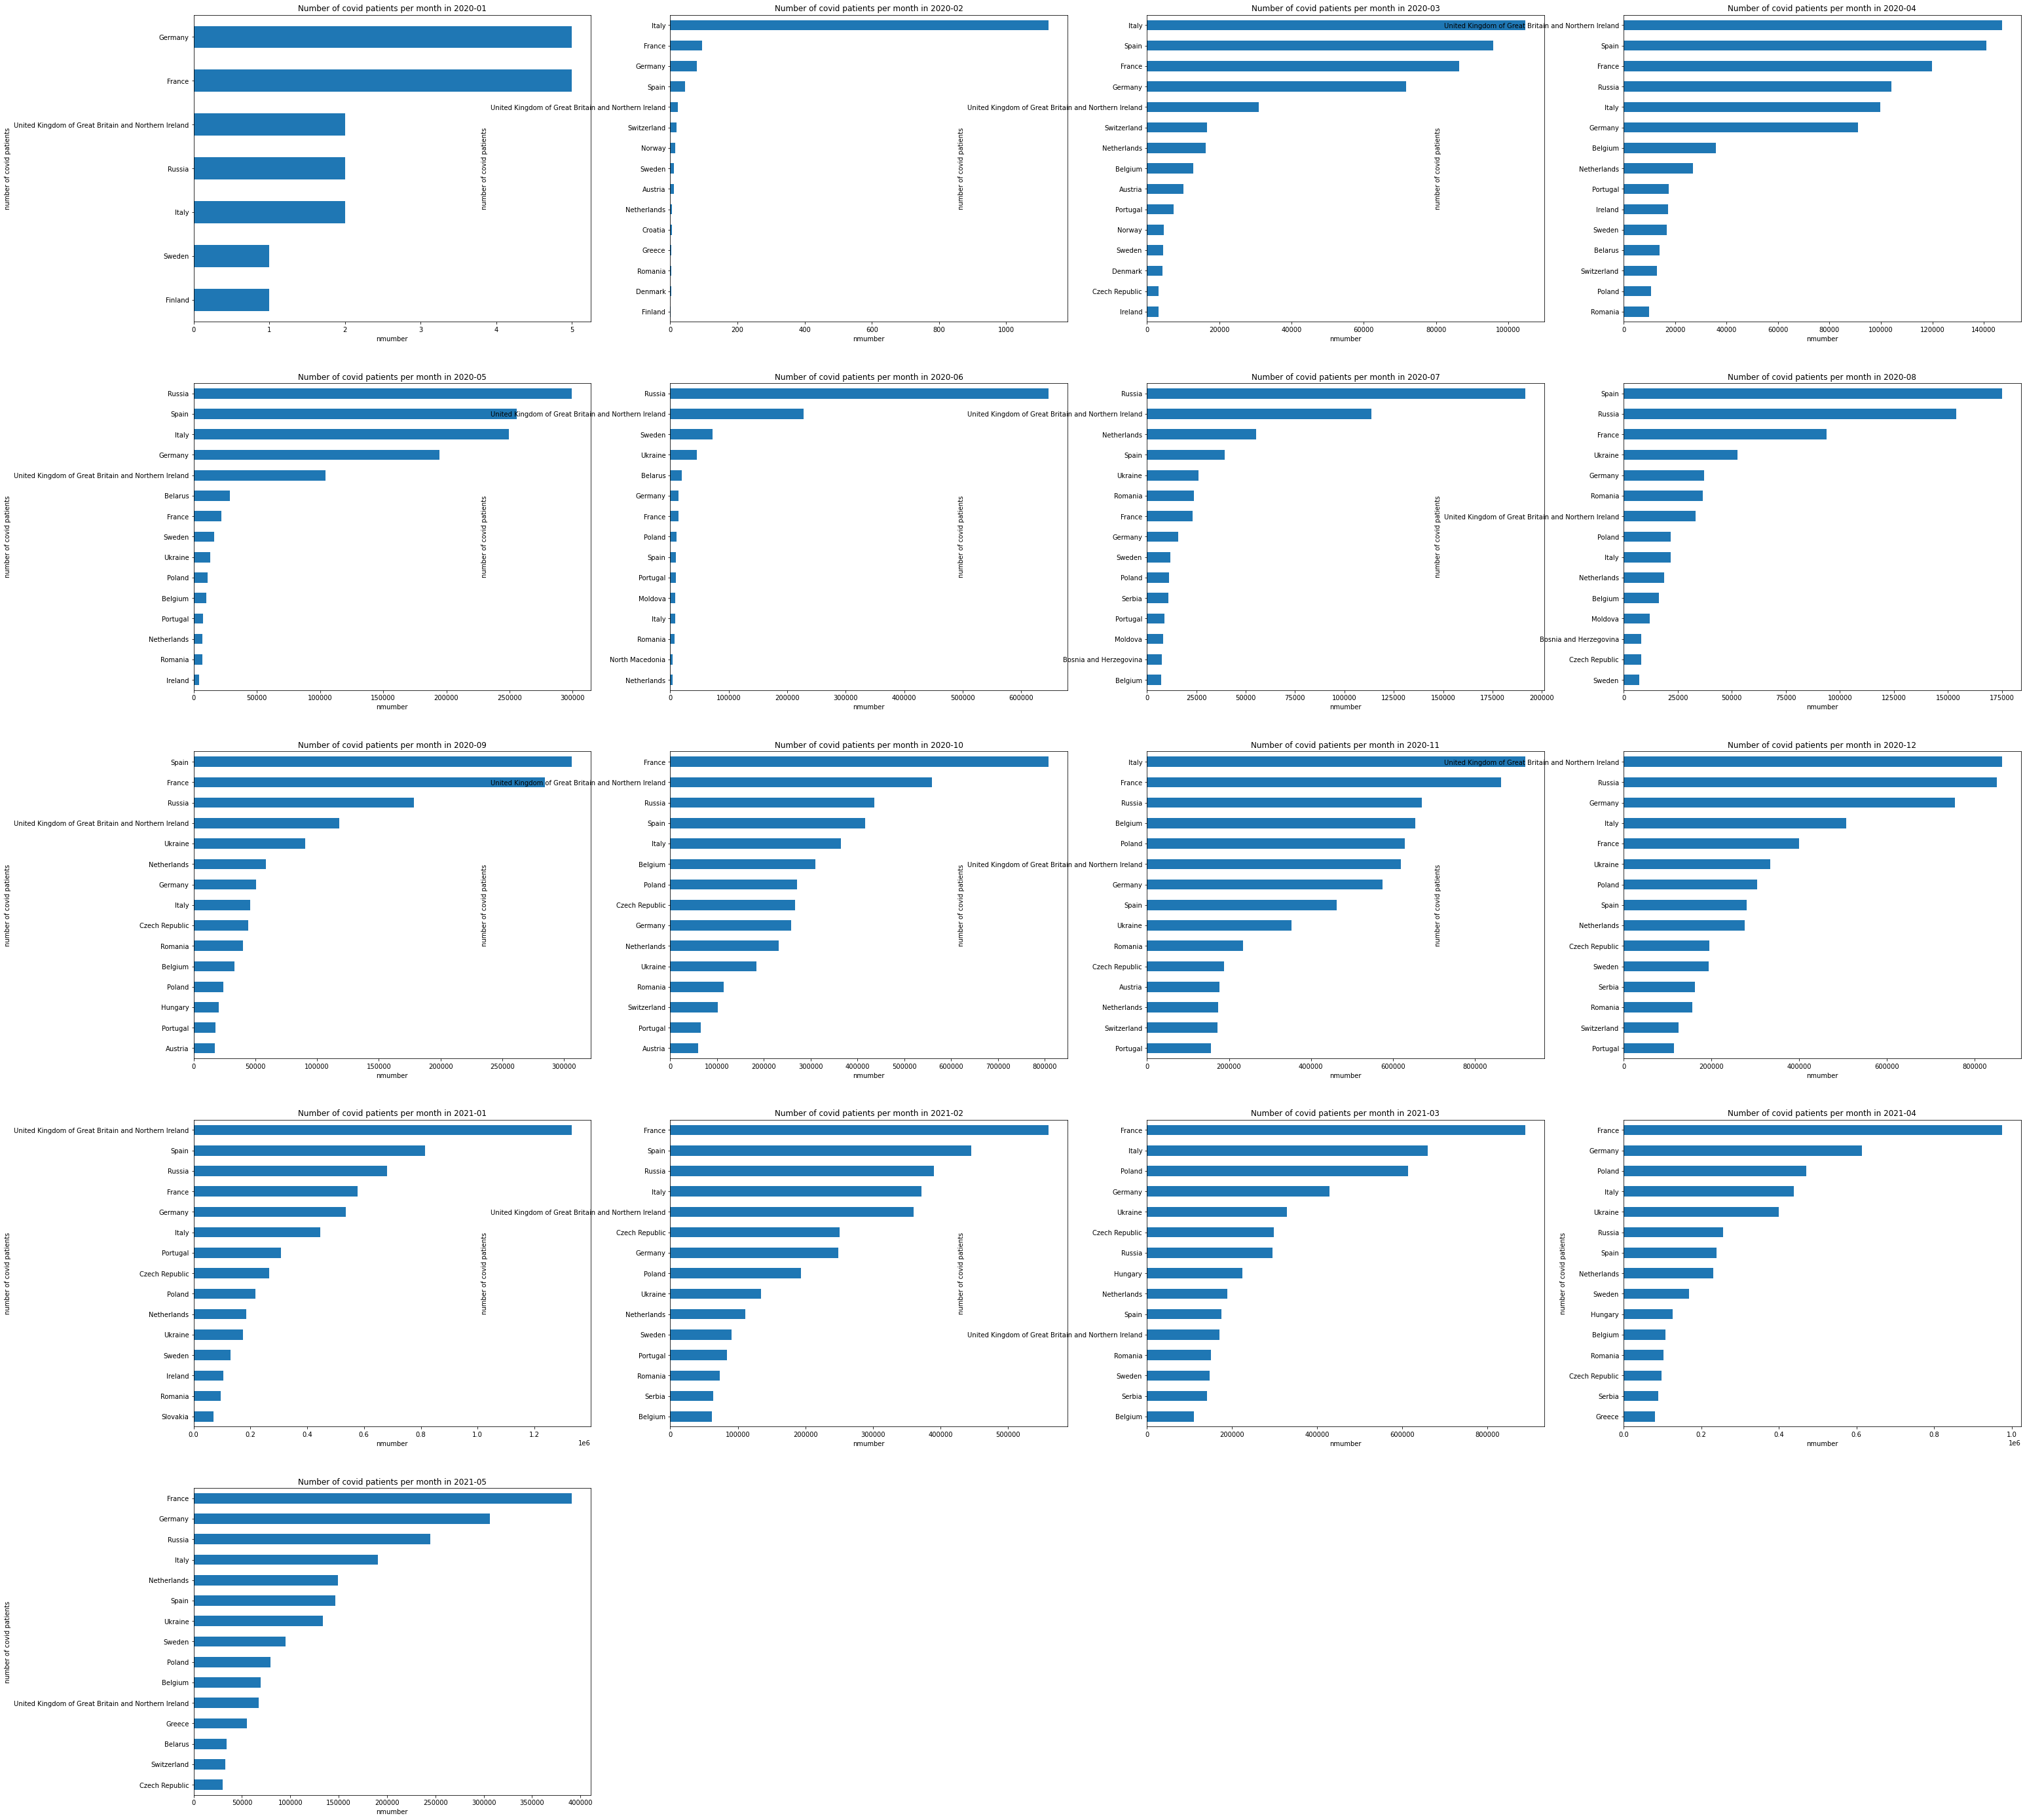

In [33]:
all_months = covid_data['ObservationMonth'].unique()
europe = covid_data.loc[covid_data.Continent=="Europe"]

fig = plt.figure(figsize=(50, 50))
a = 5
b = 4

for index, month in enumerate(all_months):
    
    plt.subplot(a,b,index+1) 
    europe.loc[europe.ObservationMonth==month].groupby(['Country'])["diffs"].sum().nlargest(15).sort_values(ascending=True).plot(kind="barh")
    plt.title('Number of covid patients per month in {}'.format(month))
    plt.ylabel('number of covid patients')
    plt.xlabel('nmumber')
    plt.grid(False)
    
plt.show() 

In [34]:
europe_all_data = covid_data.loc[covid_data.Continent=="Europe"].groupby(['Country'])["diffs"].sum().reset_index()
europe_all_data.head()

,Country,diffs
0,Albania,132297.0
1,Andorra,13693.0
2,Austria,644209.0
3,Belarus,392629.0
4,Belgium,1566567.0


In [35]:
covid_data_asia['ObservationDate'] = covid_data_asia['ObservationDate'].astype(str)    
#plot
fig = px.choropleth(covid_data_asia, locations="country_code",
                    color="CUMSUM_C",
                    hover_name="country_code",
                    animation_frame="ObservationDate",
                    title = "Daily new COVID cases",
                    scope ='asia',  color_continuous_scale=px.colors.sequential.PuRd)
 
fig["layout"].pop("updatemenus")
fig.show()

In [36]:
covid_data_europe = covid_data[covid_data.Continent == 'Europe']
#select entries with the continent as asia
covid_data_europe["ObservationDate"] = covid_data_europe["ObservationDate"].astype(str)
covid_data_europe.head(10)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,SNo,ObservationDate,State,Country,Last Update,Confirmed,Deaths,Recovered,diffs,country_code,ObservationMonth,Continent
128,129,2020-01-24,Unknown,France,2020-01-24 17:00:00,2.0,0.0,0.0,2.0,FRA,2020-01,Europe
171,172,2020-01-25,Unknown,France,2020-01-25 17:00:00,3.0,0.0,0.0,1.0,FRA,2020-01,Europe
219,220,2020-01-26,Unknown,France,2020-01-26 16:00:00,3.0,0.0,0.0,0.0,FRA,2020-01,Europe
268,269,2020-01-27,Unknown,France,2020-01-27 23:59:00,3.0,0.0,0.0,0.0,FRA,2020-01,Europe
321,322,2020-01-28,Unknown,France,2020-01-28 23:00:00,4.0,0.0,0.0,1.0,FRA,2020-01,Europe
330,331,2020-01-28,Bavaria,Germany,2020-01-28 23:00:00,4.0,0.0,0.0,4.0,DEU,2020-01,Europe
375,376,2020-01-29,Unknown,France,2020-01-29 19:30:00,5.0,0.0,0.0,1.0,FRA,2020-01,Europe
384,385,2020-01-29,Bavaria,Germany,2020-01-29 19:30:00,4.0,0.0,0.0,0.0,DEU,2020-01,Europe
385,386,2020-01-29,Unknown,Finland,2020-01-29 19:30:00,1.0,0.0,0.0,1.0,FIN,2020-01,Europe
432,433,2020-01-30,Unknown,France,2020-01-30 16:00:00,5.0,0.0,0.0,0.0,FRA,2020-01,Europe


In [37]:
covid_data_europe = covid_data_europe.groupby(['ObservationDate','country_code'])['diffs'].sum().reset_index()
covid_data_europe['CUMSUM_C'] = covid_data_europe.groupby('country_code')['diffs'].cumsum().fillna(0)
covid_data_europe.tail()

,ObservationDate,country_code,diffs,CUMSUM_C
20293,2021-05-29,SVN,353.0,253493.0
20294,2021-05-29,SWE,0.0,1113883.0
20295,2021-05-29,UGA,3241.0,4823910.0
20296,2021-05-29,UKR,3230.0,2281576.0
20297,2021-05-29,VAT,0.0,28.0


In [38]:
covid_data_europe['ObservationDate'] = covid_data_europe['ObservationDate'].astype(str)    
#plot
fig = px.choropleth(covid_data_europe, locations="country_code",
                    color="CUMSUM_C",
                    hover_name="country_code",
                    animation_frame="ObservationDate",
                    title = "Daily new COVID cases",
                    scope ='europe',  color_continuous_scale=px.colors.sequential.PuRd)
 
#fig["layout"].pop("updatemenus")
fig.show()